In [ ]:
import fastf1 as ff1
import pandas as pd
from fastf1 import utils
from matplotlib import pyplot as plt
from fastf1 import plotting

ff1.Cache.enable_cache('2023Australia') 
race = ff1.get_session(2023, 'Astralia', 'R')
race_laps = race.load_laps(with_telemetry=True)
race.load()
stint = 2

race_laps['LapTimeSeconds'] = race_laps['LapTime'].dt.total_seconds()
race_laps = race_laps.loc[(race_laps['PitOutTime'].isnull() & race_laps['PitInTime'].isnull() & race_laps['IsAccurate']==True) & race_laps['LapNumber'].between(11, 58, inclusive = True)]

race_laps = race_laps.loc[((race_laps['Driver'] == "VER")  & (race_laps['IsAccurate']==True)) | 
                          ((race_laps['Driver'] == "SAI")  & (race_laps['IsAccurate']==True)) |
                          ((race_laps['Driver'] == "ALO")  & (race_laps['IsAccurate']==True)) |
                          ((race_laps['Driver'] == "PER")  & (race_laps['IsAccurate']==True)) |
                          ((race_laps['Driver'] == "LEC")  & (race_laps['IsAccurate']==True)) |
                          ((race_laps['Driver'] == "HAM")  & (race_laps['IsAccurate']==True)) ] 


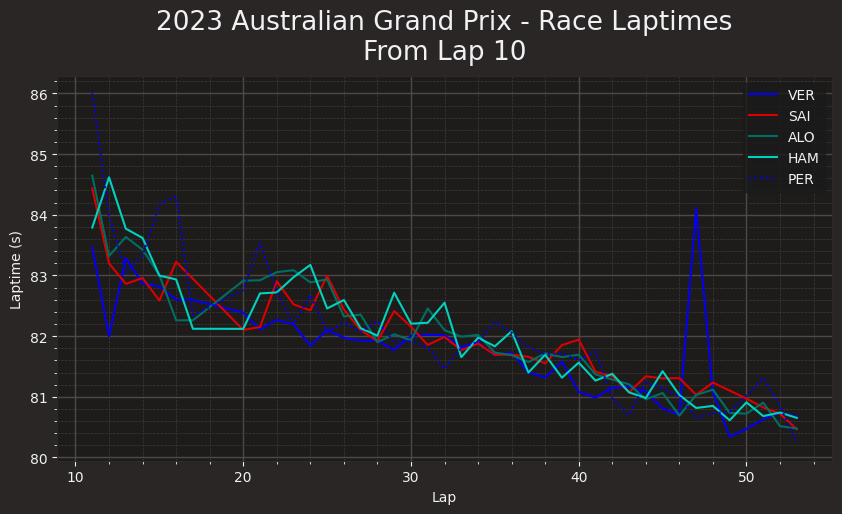

In [61]:
drivers_to_visualize = pd.unique(race_laps.Driver)


# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [10, 5]

# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots()
# Lap-by-lap longrun comparison
for driver in drivers_to_visualize:
    driver_laps = race_laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team', 'TyreLife']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    y = seconds=driver_laps['LapTimeSeconds']
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax.plot(x, y, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle)
    
    # Append labels
    ax.set(ylabel = 'Laptime (s)')
    ax.set(xlabel = 'Lap')
    
    # Set title
    ax.set_title(f"{race.event.year} {race.event.EventName} - {race.name} Laptimes\nFrom Lap 10")

    # Generate legend
    ax.legend()
    visualized_teams.append(team)
    

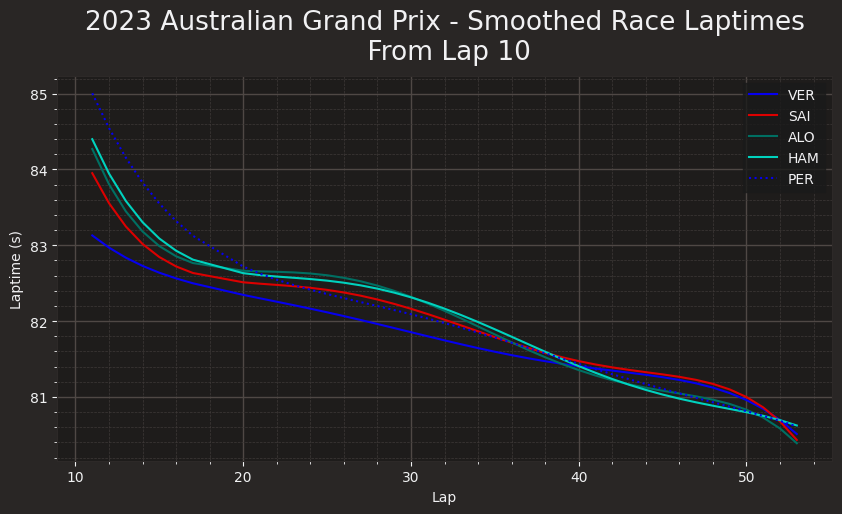

In [62]:
drivers_to_visualize = pd.unique(race_laps.Driver)

# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []
ff1.plotting.setup_mpl()
# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [10, 5]

# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots()
# Lap-by-lap longrun comparison
for driver in drivers_to_visualize:
    driver_laps = race_laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    #y = seconds=driver_laps['LapTimeSeconds']
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax.plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle)
    
    # Append labels
    ax.set(ylabel = 'Laptime (s)')
    ax.set(xlabel = 'Lap')
    
    # Set title
    ax.set_title(f"{race.event.year} {race.event.EventName} - Smoothed {race.name} Laptimes\n From Lap 10")

    # Generate legend
    ax.legend()
    visualized_teams.append(team)

# Race strategies

In [ ]:
import fastf1 as ff1
import pandas as pd
from fastf1.core import Laps
from fastf1 import plotting
from fastf1 import utils
from matplotlib import pyplot as plt
from timple.timedelta import strftimedelta
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm

ff1.Cache.enable_cache('2023Australia')
race = ff1.get_session(2023, 'Australia', 'R')
race_laps = race.load_laps(with_telemetry=True)



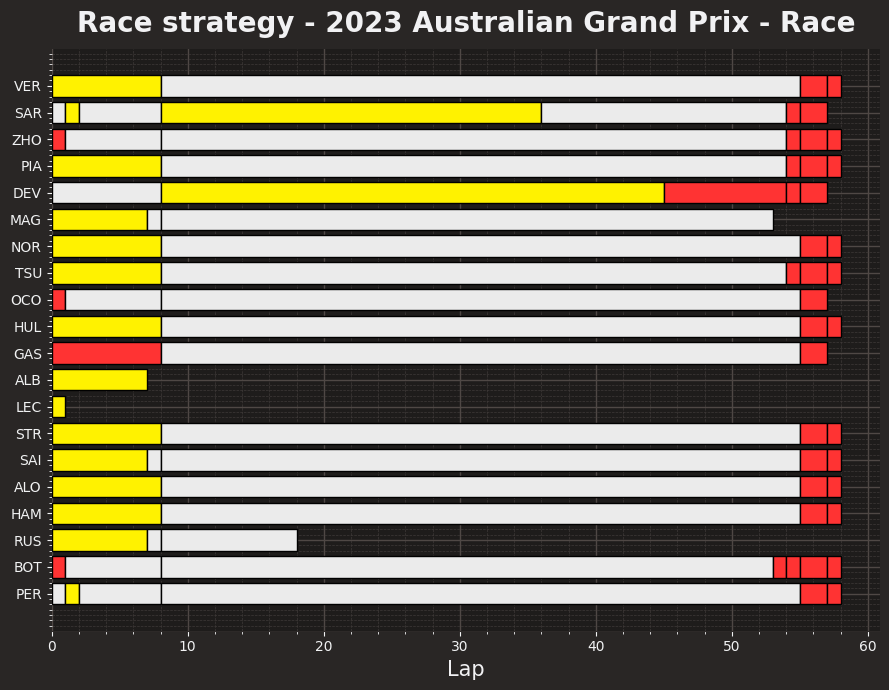

In [73]:
driver_stints = race_laps[['Driver', 'Stint', 'Compound', 'LapNumber']].groupby(
    ['Driver', 'Stint', 'Compound']
).count().reset_index()

driver_stints = driver_stints.rename(columns={'LapNumber': 'StintLength'})

driver_stints = driver_stints.sort_values(by=['Stint'])

compound_colors = {
    'SOFT': '#FF3333',
    'MEDIUM': '#FFF200',
    'HARD': '#EBEBEB',
    'INTERMEDIATE': '#39B54A',
    'WET': '#00AEEF',
}

plt.rcParams["figure.figsize"] = [9, 7]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

for driver in race.results['Abbreviation']:
    stints = driver_stints.loc[driver_stints['Driver'] == driver]
    
    previous_stint_end = 0
    for _, stint in stints.iterrows():
        plt.barh(
            [driver], 
            stint['StintLength'], 
            left=previous_stint_end, 
            color=compound_colors[stint['Compound']], 
            edgecolor = "black"
        )
        
        previous_stint_end = previous_stint_end + stint['StintLength']
        
# Set title
plt.title(f'Race strategy - {race.event.year} {race.event.EventName} - {race.name}', fontsize=20, fontweight = 'bold')
        
# Set x-label
plt.xlabel('Lap', fontsize=15)

# Invert y-axis 
plt.gca().invert_yaxis()

# Remove frame from plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

# Velocità massime

In [ ]:
import fastf1 as ff1
import pandas as pd
from fastf1.core import Laps
from fastf1 import plotting
from fastf1 import utils
from matplotlib import pyplot as plt
from timple.timedelta import strftimedelta
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm

ff1.Cache.enable_cache('2023Australia') 
fp = ff1.get_session(2023, 'Australia', 'R')
fp_laps = fp.load_laps(with_telemetry=True)
fp.load()

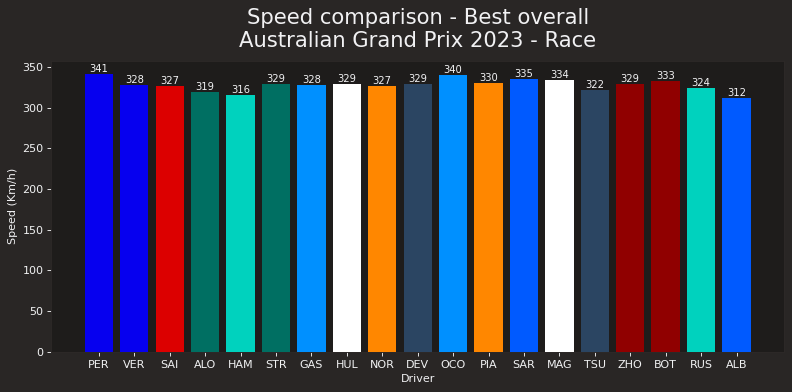

In [94]:
from collections import OrderedDict

#ricavo la lista di tutti i piloti
drivers = pd.unique(fp.laps['Driver'])
#elimino i tempi in cui i piloti erano in giro in o out
fp_laps = fp_laps.loc[(fp_laps['PitOutTime'].isnull() & fp_laps['PitInTime'].isnull() & fp_laps['IsAccurate'] == True)]

#dizionario dove inerirò tutte le massime velocità, le chiavi sono i nom dei piloti 
max_speed_dict = dict.fromkeys(drivers)

for driver in drivers:
    if not driver == "LEC":
        max_speed_dict[driver] = max(fp_laps.pick_driver(driver).get_car_data()['Speed'])

best_laps = list()
for driver in drivers:
    if not driver == "LEC":
        best_laps.append(fp.laps.pick_driver(driver).pick_fastest())
fastest_laps = Laps(best_laps).sort_values(by='LapTime').reset_index(drop=True)

team_colors = list()
team_color_drvrs = list()
for index, lap in fastest_laps.iterlaps():
        team_color_drvrs.append(lap['Driver'])
        color = ff1.plotting.team_color(lap['Team'])
        team_colors.append(color)

max_speed_dict_ordered = OrderedDict((k, max_speed_dict[k]) for k in team_color_drvrs)
max_speed_dict_ordered = dict(max_speed_dict_ordered)

ff1.plotting.setup_mpl()
figure(figsize=(10, 5), dpi=80)
plt.bar_label(plt.bar(range(len(max_speed_dict_ordered)), list(max_speed_dict_ordered.values()), align='center', color=team_colors), fontsize = 9)
plt.xticks(range(len(max_speed_dict_ordered)), list(max_speed_dict_ordered.keys()))
plt.title(f"Speed comparison - Best overall\n"
          f"{fp.event['EventName']} {fp.event.year} - {fp.name}")

plt.xlabel('Driver', fontsize=10)
plt.ylabel('Speed (Km/h)', fontsize=10)
plt.show()

